# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import mythinkstats as mts
import numpy as np
import pandas as pd
import random

print('Ready')

Ready


## Least squares

One more time, let's load up the NSFG data.

In [2]:
preg = mts.nsfg_read_data('ThinkStats2/code/2002FemPreg.dct', 'ThinkStats2/code/2002FemPreg.dat.gz')
live = preg[preg.outcome == 1]
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
len(live)

9038

The following function computes the intercept and slope of the least squares fit.

In [3]:
# Implemented mts.fit_least_squares

Here's the least squares fit to birth weight as a function of mother's age.

In [4]:
m, b = mts.fit_least_squares(live.agepreg, live.totalwgt_lb)
m, b

(0.017453851471802753, 6.8303969733110526)

The intercept is often easier to interpret if we evaluate it at the mean of the independent variable.

In [5]:
'Weight evaluated at mean age = %.2lf lbs' % (b + m * live.agepreg.mean())

'Weight evaluated at mean age = 7.27 lbs'

And the slope is easier to interpret if we express it in pounds per decade (or ounces per year).

In [6]:
print('Weight increases by %.3lf oz. every year' % (m * 16))

Weight increases by 0.279 oz. every year


The following function evaluates the fitted line at the given `xs`.

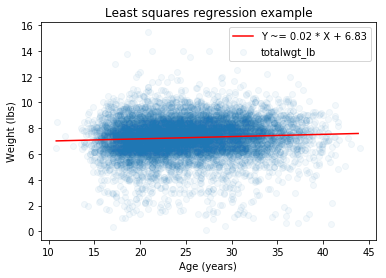

In [7]:
plt.scatter(live.agepreg, live.totalwgt_lb, alpha=0.05)
xlsf = np.arange(min(live.agepreg), max(live.agepreg))
plt.plot(xlsf, xlsf * m + b, color='red', label='Y ~= %.2lf * X + %.2lf' % (m, b))
plt.legend()
plt.xlabel('Age (years)')
plt.ylabel('Weight (lbs)')
plt.title('Least squares regression example')
plt.show()

Here's a scatterplot of the data with the fitted line.

## Residuals

The following functon computes the residuals.

In [8]:
# Implemented mts.fit_residual.

Now we can add the residuals as a column in the DataFrame.

In [9]:
live['residual_age_wgt'] = mts.est_residual(live.agepreg, live.birthwgt_lb, m, b)
live['residual_age_wgt'].head(5)

0    0.590833
1   -0.515461
2    1.919489
3   -0.141599
4   -1.150326
Name: residual_age_wgt, dtype: float64

To visualize the residuals, I'll split the respondents into groups by age, then plot the percentiles of the residuals versus the average age in each group.

First I'll make the groups and compute the average age in each group.

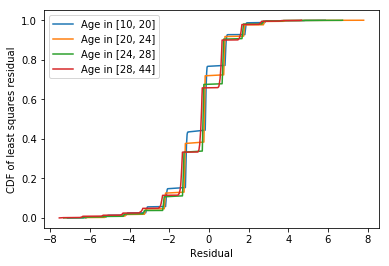

In [10]:
# I still don't find Downey's percentile plots particularly useful given the 
# multiple steps required to make them. Below I plot CDFs of the least squares 
# residuals showing that residuals are distributed roughly identically for each age group.
agepreg_pmf = live.agepreg.value_counts(normalize=True)
agepreg_cdf = mts.pmf_to_cdf(agepreg_pmf)
bins = [mts.cdf_percentile(agepreg_cdf, x) for x in [25, 50, 75]]
groups = live.groupby(np.digitize(live.agepreg, bins))

for i, group in groups:
    residual_pmf = group.residual_age_wgt.value_counts(normalize=True)
    residual_cdf = mts.pmf_to_cdf(residual_pmf)
    plt.plot(residual_cdf.index, residual_cdf.values, label='Age in [%d, %d]' % (
        group.agepreg.min(), group.agepreg.max()))
    
plt.xlabel('Residual')
plt.ylabel('CDF of least squares residual')
plt.legend()
plt.show()

## Visualizing uncertainty

To show the uncertainty of the estimated slope and intercept, we can generate a fitted line for each resampled estimate and plot them on top of each other.

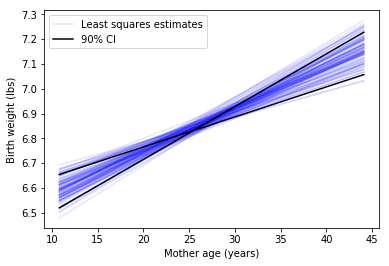

In [11]:
iters = 100
X = np.array([min(live.agepreg), max(live.agepreg)])
M, B = [], []
for _ in range(iters):
    sample = live.sample(n=len(live), replace=True)
    m, b = mts.fit_least_squares(sample.agepreg, sample.birthwgt_lb)
    plt.plot(X, m * X + b, color='blue', alpha=0.1,
             label=None if _ > 0 else 'Least squares estimates')
    M.append(m)
    B.append(b)
    
M_pmf = pd.Series(M).value_counts(normalize=True)
M_cdf = mts.pmf_to_cdf(M_pmf)
B_pmf = pd.Series(B).value_counts(normalize=True)
B_cdf = mts.pmf_to_cdf(B_pmf)

plt.plot(X, mts.cdf_percentile(M_cdf, 5) * X + mts.cdf_percentile(B_cdf, 95), color='black', label='90% CI')
plt.plot(X, mts.cdf_percentile(M_cdf, 95) * X + mts.cdf_percentile(B_cdf, 5), color='black')

plt.ylabel('Birth weight (lbs)')
plt.xlabel('Mother age (years)')
plt.legend()
plt.show()

Or we can make a neater (and more efficient plot) by computing fitted lines and finding percentiles of the fits for each value of the dependent variable.

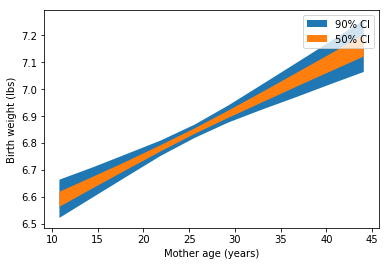

In [12]:
# To make the pretty CI plot, find the confidence interval's upper and lower bounds
# at every X point and fill in the space between them.

iters = 1000
X = np.linspace(min(live.agepreg), max(live.agepreg), 10)
Y = np.zeros((iters, len(X)))
for i in  range(iters):
    sample = live.sample(n=len(live), replace=True)
    m, b = mts.fit_least_squares(sample.agepreg, sample.birthwgt_lb)
    Y[i] = m * X + b

# 90% confidence interval.
Y_low, Y_high = [], []
for j in range(Y.shape[1]):
    Y_pmf = pd.Series(Y[:,j]).value_counts(normalize=True)
    Y_cdf = mts.pmf_to_cdf(Y_pmf)
    Y_low.append(mts.cdf_percentile(Y_cdf, 5))
    Y_high.append(mts.cdf_percentile(Y_cdf, 95))
plt.fill_between(X, Y_low, Y_high, label='90% CI')

# 50% confidence interval.
Y_low, Y_high = [], []
for j in range(Y.shape[1]):
    Y_pmf = pd.Series(Y[:,j]).value_counts(normalize=True)
    Y_cdf = mts.pmf_to_cdf(Y_pmf)
    Y_low.append(mts.cdf_percentile(Y_cdf, 25))
    Y_high.append(mts.cdf_percentile(Y_cdf, 75))    
plt.fill_between(X, Y_low, Y_high, label='50% CI')

plt.ylabel('Birth weight (lbs)')
plt.xlabel('Mother age (years)')
plt.legend()
plt.show()

## Coefficient of determination



The coefficient compares the variance of the residuals to the variance of the dependent variable.

In [13]:
# Implemented mts.est_rsquared.

For birth weight and mother's age $R^2$ is very small, indicating that the mother's age predicts a small part of the variance in birth weight.

In [14]:
m, b = mts.fit_least_squares(live.agepreg, live.birthwgt_lb)
r2 = mts.est_rsquared(live.agepreg, live.birthwgt_lb, m, b)
r2

0.004606971642877267

We can confirm that $R^2 = \rho^2$:

In [15]:
print('rho', mts.pearson_correlation(live.agepreg, live.birthwgt_lb))
print('R', np.sqrt(r2))

rho 0.06786716608358145
R 0.0678746760056891


To express predictive power, I think it's useful to compare the standard deviation of the residuals to the standard deviation of the dependent variable, as a measure RMSE if you try to guess birth weight with and without taking into account mother's age.

In [16]:
print('Std(ys)', live.birthwgt_lb.std())
print('Std(res)', mts.est_residual(live.agepreg, live.birthwgt_lb, m, b).std())

Std(ys) 1.410677213085378
Std(res) 1.4074239869208252


As another example of the same idea, here's how much we can improve guesses about IQ if we know someone's SAT scores.

In [17]:
var_ys = 15**2
rho = 0.72
r2 = rho**2
var_res = (1 - r2) * var_ys
std_res = np.sqrt(var_res)
std_res

10.409610943738484

## Hypothesis testing with slopes

Here's a `HypothesisTest` that uses permutation to test whether the observed slope is statistically significant.

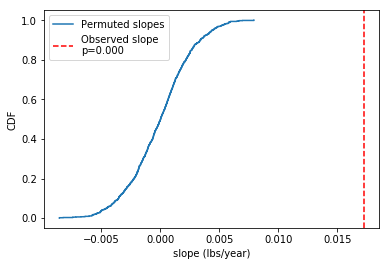

In [18]:
# Null hypothesis: there is no relationship between age and weight, the resulting least-squares slope is 0.
# Simulate the null hypothesis by computing the slope for random permutations of age and weight.
# The p-value is computed with respect to the simulated distribution of slopes.
obs_m, _ = mts.fit_least_squares(live.agepreg, live.birthwgt_lb)

iters = 1000
sim_M = []
for _ in range(iters):
    m, b = mts.fit_least_squares(live.agepreg, live.birthwgt_lb.sample(frac=1, replace=False))
    sim_M.append(m)
    
sim_M_pmf = pd.Series(sim_M).value_counts(normalize=True)
sim_M_cdf = mts.pmf_to_cdf(sim_M_pmf)
pval = mts.cdf_pvalue(sim_M_cdf, obs_m)

plt.step(sim_M_cdf.index, sim_M_cdf.values, label='Permuted slopes')
plt.axvline(obs_m, label='Observed slope\np=%.3lf' % pval, color='red', linestyle='--')
plt.ylabel('CDF')
plt.xlabel('slope (lbs/year)')
plt.legend()
plt.show()

We can also use resampling to estimate the sampling distribution of the slope.

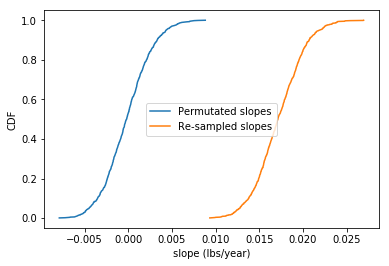

In [19]:
iters = 1000
prm_M, smp_M = [], []
for _ in range(iters):
    # Slope for a random permutation.
    m, b = mts.fit_least_squares(live.agepreg, live.birthwgt_lb.sample(frac=1, replace=False))
    prm_M.append(m)
    
    # Slope for a random sample with replacement.
    sample = live.sample(frac=1, replace=True)
    m, b = mts.fit_least_squares(sample.agepreg, sample.birthwgt_lb)
    smp_M.append(m)
    
# PMF and CDF for both types of slope.
prm_M_pmf = pd.Series(prm_M).value_counts(normalize=True)
prm_M_cdf = mts.pmf_to_cdf(prm_M_pmf)
smp_M_pmf = pd.Series(smp_M).value_counts(normalize=True)
smp_M_cdf = mts.pmf_to_cdf(smp_M_pmf)

# Plot CDF.
plt.plot(prm_M_cdf.index, prm_M_cdf.values, label='Permutated slopes')
plt.plot(smp_M_cdf.index, smp_M_cdf.values, label='Re-sampled slopes')
plt.ylabel('CDF')
plt.xlabel('slope (lbs/year)')
plt.legend()
plt.show()

The distribution of slopes under the null hypothesis, and the sampling distribution of the slope under resampling, have the same shape, but one has mean at 0 and the other has mean at the observed slope.

To compute a p-value, we can count how often the estimated slope under the null hypothesis exceeds the observed slope, or how often the estimated slope under resampling falls below 0.

## Resampling with weights

Resampling provides a convenient way to take into account the sampling weights associated with respondents in a stratified survey design.

The following function resamples rows with probabilities proportional to weights.

In [20]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

We can use it to estimate the mean birthweight and compute SE and CI.

In [21]:
iters = 1000
sample_means = np.zeros((iters,))
p = live.finalwgt.values / sum(live.finalwgt)
for i in range(iters):
    ii = np.random.choice(np.arange(len(live)), len(live), p=p)
    sample_means[i] = live.totalwgt_lb.values[ii].mean()

print('Estimated mean = %.3lf lbs, standard error = %.3lf' % (sample_means.mean(), sample_means.std()))

Estimated mean = 7.347 lbs, standard error = 0.014


And here's what the same calculation looks like if we ignore the weights.

In [22]:
# Estimate population mean by resampling without weighting.
iters = 1000
sample_means = np.zeros((iters,))
for i in range(iters):
    sample_means[i] = live.sample(frac=1, replace=True).totalwgt_lb.mean()

print('Estimated mean = %.3lf lbs, standard error = %.3lf' % (sample_means.mean(), sample_means.std()))

Estimated mean = 7.267 lbs, standard error = 0.015


The difference is non-negligible, which suggests that there are differences in birth weight between the strata in the survey.

# Exercises

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [23]:
brfss = mts.brfss_read_data(filename='ThinkStats2/code/CDBRFS08.ASC.gz')
brfss.dropna(subset=['htm3', 'wtkg2'], inplace=True)
brfss['logwtkg2'] = np.log10(brfss.wtkg2)
len(brfss)

395832

Estimate intercept and slope.

In [24]:
m, b = mts.fit_least_squares(brfss.htm3, brfss.logwtkg2)
m, b

(0.005281454169417761, 0.9930804163932904)

Make a scatter plot of the data and show the fitted line.

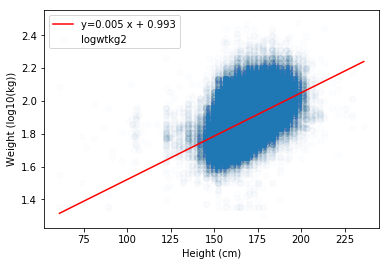

In [25]:
plt.scatter(brfss.htm3, brfss.logwtkg2, alpha=0.01)
X = np.array([min(brfss.htm3), max(brfss.htm3)])
plt.plot(X, m * X + b, label='y=%.3lf x + %.3lf' % (m, b), color='red')
plt.ylabel('Weight (log10(kg))')
plt.xlabel('Height (cm)')
plt.legend()
plt.show()

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

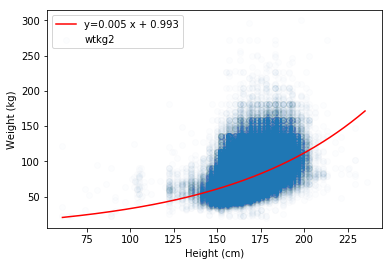

In [26]:
plt.scatter(brfss.htm3, brfss.wtkg2, alpha=0.01)
X = np.arange(min(brfss.htm3), max(brfss.htm3))
plt.plot(X, 10 ** (m * X + b), label='y=%.3lf x + %.3lf' % (m, b), color='red')
plt.ylabel('Weight (kg)')
plt.xlabel('Height (cm)')
plt.legend()
plt.show()

Plot percentiles of the residuals.

In [27]:
# These plots are a pain in the butt.

Compute correlation.

In [28]:
pcorr = mts.pearson_correlation(brfss.htm3, brfss.logwtkg2)
scorr = mts.spearman_correlation(brfss.htm3, brfss.logwtkg2)
print('Pearson correlation = %.3lf' % pcorr)
print('Spearman correlation = %.3lf' % scorr)

Pearson correlation = 0.532
Spearman correlation = 0.541


Compute coefficient of determination.

In [29]:
r2 = mts.est_rsquared(brfss.htm3, brfss.logwtkg2, m, b)
print('R^2 = %.3lf' % r2)

R^2 = 0.283


Confirm that $R^2 = \rho^2$.

In [30]:
# Solution goes here
print('R^2 - pearson^2 = %.5lf' % (r2 - pcorr**2))

R^2 - pearson^2 = 0.00000


Compute Std(ys), which is the RMSE of predictions that don't use height.

In [31]:
# Solution goes here.
print('Std(ys) = %.3lf' % brfss.logwtkg2.std())

Std(ys) = 0.103


Compute Std(res), the RMSE of predictions that do use height.

In [32]:
# Solution goes here
print('Std(res) = %.3lf' % mts.est_residual(brfss.htm3, brfss.logwtkg2, m, b).std())

Std(res) = 0.087


How much does height information reduce RMSE?

In [33]:
# Solution goes here
round(brfss.logwtkg2.std() - mts.est_residual(brfss.htm3, brfss.logwtkg2, m, b).std(), 4)

0.0158

Use resampling to compute sampling distributions for inter and slope.

In [34]:
iters = 1000
M, B = [], []
for _ in range(iters):
    sample = brfss.sample(frac=1, replace=True)
    m, b = mts.fit_least_squares(sample.htm3, sample.logwtkg2)
    M.append(m)
    B.append(b)
len(M), len(B)

(1000, 1000)

Plot the sampling distribution of slope.

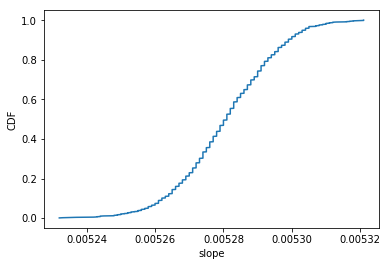

In [35]:
M_pmf = pd.Series(M).value_counts(normalize=True)
M_cdf = mts.pmf_to_cdf(M_pmf, precision=6)
plt.plot(M_cdf.index, M_cdf.values)
plt.ylabel('CDF')
plt.xlabel('slope')
plt.show()

Compute the p-value of the slope.

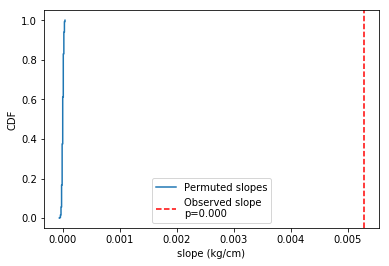

In [36]:
# Null hypothesis: there is no relationship between height and weight, the resulting least-squares slope is 0.
# Simulate the null hypothesis by computing the slope for random permutations of height and weight.
# The p-value is computed with respect to the simulated distribution of slopes.
obs_m, _ = mts.fit_least_squares(brfss.htm3, brfss.logwtkg2)

iters = 1000
sim_M = []
for _ in range(iters):
    m, b = mts.fit_least_squares(brfss.htm3, brfss.logwtkg2.sample(frac=1, replace=False))
    sim_M.append(m)
    
sim_M_pmf = pd.Series(sim_M).value_counts(normalize=True)
sim_M_cdf = mts.pmf_to_cdf(sim_M_pmf)
pval = mts.cdf_pvalue(sim_M_cdf, obs_m)

plt.step(sim_M_cdf.index, sim_M_cdf.values, label='Permuted slopes')
plt.axvline(obs_m, label='Observed slope\np=%.3lf' % pval, color='red', linestyle='--')
plt.ylabel('CDF')
plt.xlabel('slope (kg/cm)')
plt.legend()
plt.show()

Compute the 90% confidence interval of slope.

In [37]:
mts.cdf_percentile(M_cdf, 5), mts.cdf_percentile(M_cdf, 95)

(0.005258, 0.005303)

Compute the mean of the sampling distribution.

In [38]:
mts.pmf_expectation(M_pmf)

0.005280734356671989

Compute the standard deviation of the sampling distribution, which is the standard error.

In [39]:
np.sqrt(mts.pmf_variance(M_pmf))

1.4319889272463665e-05

Resample rows without weights, compute mean height, and summarize results.

In [40]:
iters = 100
sample_means = np.array([brfss.htm3.sample(len(brfss), replace=True).mean() for _ in range(iters)])
sample_means.mean(), sample_means.std()

(168.95453904686835, 0.014881444251279616)

Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [41]:
# Solution goes here
ii = np.arange(len(brfss))
p = brfss.finalwt / brfss.finalwt.sum()
get_ii = lambda: np.random.choice(ii, len(ii), p=p)
sample_means = np.array([brfss.htm3.values[get_ii()].mean() for _ in range(iters)])
sample_means.mean(), sample_means.std()

(170.4964925018695, 0.01817294958539453)

In [42]:
print('Done')

Done
